In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs

# import custom scripts
from src.plot import *
from src.data import *
from src.stats import *

%matplotlib inline
plt.style.use('ggplot')

# The Math Behind AB Testing
In this project, I try to do AB testing step by step.

## Outline
1. Set up the experiment
  * Goal of AB testing.
  * Metric and Minimum effect size.
  * Statistical power and level of significance.
2. Set up a control group and test group by selecting users at random
3. Run the test and collect data.
4. Plot the distribution of the difference between the two samples
5. Measure the probability of getting the result of the test group and the confidence interval. Check to see if there is enough statistical power and that the level of significance is achieved.
6. Consider other tradeoffs and decide if the change should be launched

## Set up the experiment

The goal of running an AB test is to evaluate if a change in a website will lead to improved performance in a specific metric. Usually a small change will be tested, like changing the color of a small button. 

Te goal of this article is to run AB test step by step.

## Variables

* Sample size
* Baseline conversion rate: usually it is the probability of control group.
* Minimum effect size: Should set before the test, since we need it to calculate the sample size. Also used to test whether practical significant or not.
* Statistical power: 80%.
* Confidence level or level of significance: 95%.

## Control Group A and Test Group B
In this project, we will manually create data. In reality, the data are collected from the website and randomly split users into two groups.

Initially, we will collect 1000 samples for each group and collect data.

## Run the Test

Let's generate data.

In [1]:
# A is control; B is experiment
N_A = 1000
N_B = 1000

Let's set the minimum effect size. It's usually used to cMinimum effect sizealculate the sample size and test whether there is a practical significant.

Here, since we don't have real data, and we want to have an experiment with significant difference, so we also use minimum effect size to generate data. 

In [11]:
# pa: actually conversion rate of control group. pb: conversion rate of experiment group
# d_hat: difference between two groups
pa = 0.10
pb = 0.12
d_hat = 0.02

In [12]:
# generate the data.
ab_data = generate_data(N_A, N_B, pa, pb)

Let's look at the data.

In [13]:
print(ab_data.head(5))
print(ab_data.shape)

converted group
0          0     A
1          0     B
2          0     B
3          0     A
4          1     B
(2000, 2)


Next, let's see how many users from each group converted. We use pivot_table to convert the original data table.

We can see that the rate difference is around 0.03, which is what we want.

Please note, due to random generation, we may need to run several time to get the data we want.

In [15]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')
ab_summary

,converted,total,rate
group,,,
A,95,1032,0.092054
B,118,968,0.121901


Now, we record the useful information.

In [16]:
p_A = ab_summary.rate[0]
p_B = ab_summary.rate[1]
A_total = ab_summary.total[0]
B_total = ab_summary.total[1]
A_converted = ab_summary.converted[0]
B_converted = ab_summary.converted[1]

## Compare the Two Samples

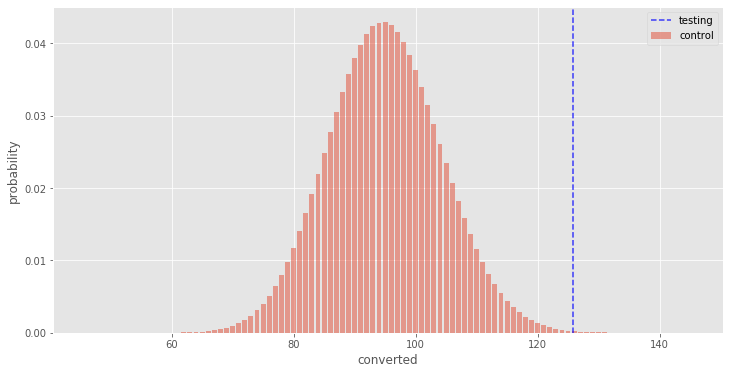

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, p_A).pmf(x)
ax.bar(x, y, alpha=0.5, label='control')
ax.axvline(x=p_B * A_total, c='blue', alpha=0.75, linestyle='--', label='testing')
plt.legend()
plt.xlabel('converted')
plt.ylabel('probability')
plt.show()

If we plot the binomial distribution that corresponds to the control group, we would get the plot above in red. If we want to evaluate the probability of getting the result from the test group based on the binomial distribution from the control group, for example, if we want to test the probability of 120 or above, then 

In [18]:
scs.binom(A_total, p_A).pmf(120)

0.0013309235456636546

We can see that the probability is very close to 0. If we are comparing this to a significance level, typically referred to as alpha, we would say that the result is drastically lower than 5% or even 1%. In other words, there was a very small chance that we would have seen this result, let alone the blue dash line.

We can plot the data from both groups as binomial distributions.

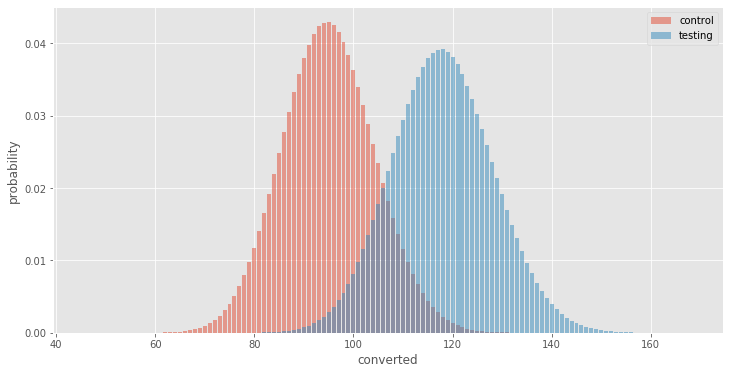

In [19]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.bar(xA, yA, alpha=0.5, label='control')
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.bar(xB, yB, alpha=0.5, label='testing')
plt.legend()
plt.xlabel('converted')
plt.ylabel('probability')
plt.show()

We can see that the test group converted more users than the control group. One may get a result that the two groups are significant different from the above pictures. But actually it is not what we want, because it is not the hypothesis test of conversion rate. Also, since the sample size for each group is not the same, it's not fair to directly compare.

Consider the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) for the control group.

$$ X \sim Bernoulli(p) $$
where p is the true conversion probability of the control group.

According to the properties of the Bernoulli distribution, the mean and variance are as follows:

$$ E(X) = p $$

$$ Var(X) = p(1-p) $$ 

According to the central limit theorem, by calculating many sample means we can approximate the true mean of the population from which the data for the control group was taken. The distribution of the sample means will be normally distributed around the true mean with a standard deviation equal to the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).

The [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error) is given as:

$$ \sigma_{\bar{x}} = \frac{s}{\sqrt{n}} = \frac{\sqrt{p(1-p)}}{\sqrt{n}} $$

The same can be done with the alternate group.

Therefore, we can represent both groups as a normal distribution with the following properties

$$ \hat{p} \sim Normal\left(\mu = p, \: \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}}\right) $$

In [20]:
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)

SE_A, SE_B

(0.008999368847660007, 0.010515681666302916)

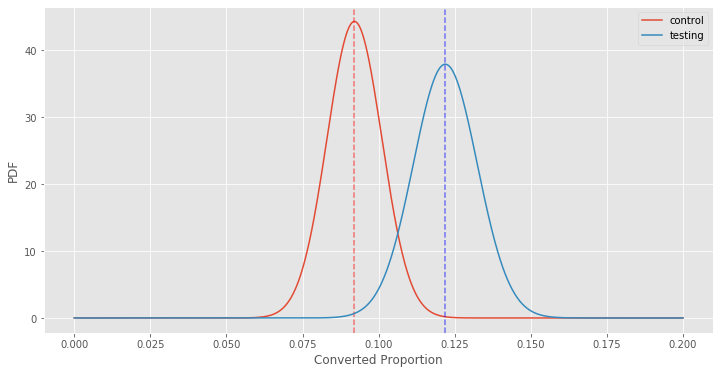

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(0, .2, 1000)
yA = scs.norm(p_A, SE_A).pdf(xA)
ax.plot(xA, yA, label='control')
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')

xB = np.linspace(0, .2, 1000)
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB, label='testing')
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Converted Proportion')
plt.ylabel('PDF')
plt.show()

The dashed lines represent the mean conversion rate for each group. The distance between the red dashed line and the blue dashed line is equal to d_hat.

$$ \hat{d} = \hat{p}_B - \hat{p}_A $$

## Back to the Null and Alternate Hypothesis
Recall that the null hypothesis states that the difference in probability between the two groups is zero. We should construct a distribution of this difference, since for any A/B experiment our value for p each come from a two different distributions and the difference will have its own variance.

$$ H_0: d = 0 $$

$$ \hat{d} \sim Normal(0, \: SE_{pool}) $$

$$ H_A: d = p_B - p_A $$

$$ \hat{d} \sim Normal(d, \: SE_{pool}) $$

## Variance of the Sum
The [variance of the sum](https://en.wikipedia.org/wiki/Variance) (of two random independent variables) is the sum of the variances.

$$ Var(X + Y) = Var(X) + Var(Y) $$
$$ Var(X - Y) = Var(X) + Var(Y) $$

Because the distribution for the difference is calculated from two normal distributions, we can assume that the difference will be normally distributed.

The null hypothesis is the normal distribution of the difference with a mean of zero. 

The alternate hypothesis is the normal distribution of the difference with a mean of the difference in the means of the two groups. 

The null hypothesis and alternate hypothesis will the same variance which will be the sum of the variances for the control group and the experiment group.

$$ Var(\hat{d}) = Var(\hat{p}_B - \hat{p}_A) = Var(\hat{p}_A) + Var(\hat{p}_B) = \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} $$

The standard deviation will be the square root of the variance.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} } $$

## Pooled Variance
We can put this equation in terms of $s$, where $s$ is the standard deviation of the Bernoulli distribution.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_A^2}{n_A} + \frac{s_B^2}{n_B} } $$

The is the [Satterthwaite approximation](http://www.statisticshowto.com/satterthwaite-approximation/) for pooled variance.

If we pool the probability like the [Udacity lesson](https://www.youtube.com/watch?v=iub8yWiO84I) and then calculate the variance for the pooled probability, we would end up with the same equation for pooled variance shown in the lesson.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_p^2}{n_A} + \frac{s_p^2}{n_B} } = \sqrt{ s_p \left(\frac{1}{n_A} + \frac{1}{n_B} \right) } = \sqrt{ \hat{p}_p(1-\hat{p}_p) \left(\frac{1}{n_A} + \frac{1}{n_B} \right) } $$

$$ \hat{p}_p = \frac{p_A N_A + p_B N_B}{N_A + N_B} $$

### Statistical power
We now need to consider the confidence level of the test. We will plot the null hypothesis and the alternative hypothesis.

* The null hypothesis is that the change made for the experiment group **would result in no change** in the conversion rate.
* The alternative hypothesis is that the change for the experiment group **would result in a detectable change** in the conversion rate.

We can represent the null hypothesis by plotting the distribution of the difference between the control and test group. According to the Udacity course, the distribution will be normal with a mean of zero and a standard deviation equal to the pooled standard error. This is an application of the central limit theorem. 

According to statisticshowto:
The Central Limit Theorem states that the sampling distribution of the sample means approaches a normal distribution as the sample size gets larger — no matter what the shape of the population distribution.


We can prove this by the following: 
Our control and test groups are samples taken from a population. 
We are taking the mean of each group's distribution, which in this case is binomial, and we are finding the difference Let's demonstrate if this distribution is truly normal. We can use our data generation script to repeat this process 1000 times. We will set the variable, `d_hat`, to zero to represent the case where the null hypothesis is true.

### Pooled Standard Error

$$ SE_p = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$ 

$$ SE_p = S_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}} = \sqrt{S_p^2\left(\frac{1}{n_1} + \frac{1}{n_2} \right)} = \sqrt{ p_p(1-p_p) \left(\frac{1}{n_1} + \frac{1}{n_2} \right)} $$

$$ SE_p = \sqrt{ p_p(1-p_p) \left(\frac{1}{n_1} + \frac{1}{n_2} \right)} $$

In [22]:
bcr = p_A
d_hat = p_B - p_A

In [23]:
N_A, N_B, bcr, d_hat

(1000, 1000, 0.09205426356589147, 0.02984656288038952)

From the following plot, we can see that the power of our test is very low.

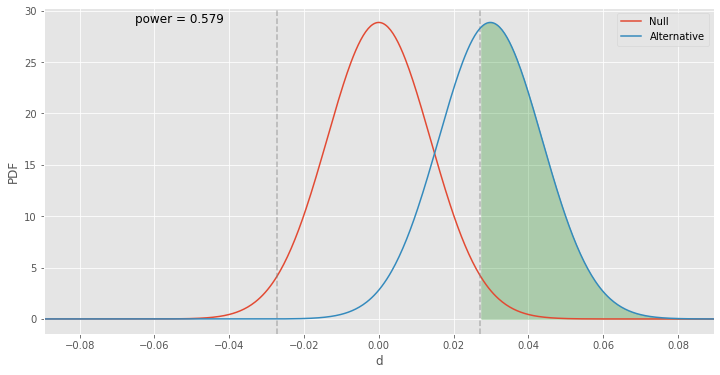

In [24]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

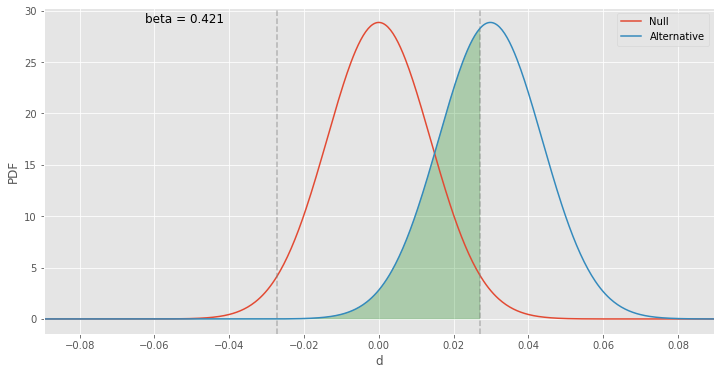

In [25]:
abplot(N_A, N_B, bcr, d_hat, show_beta=True)

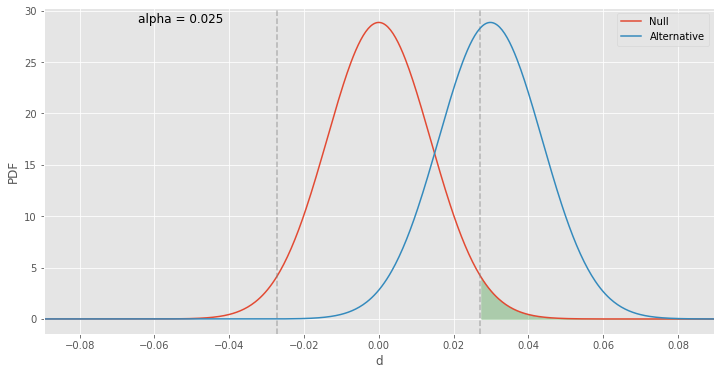

In [26]:
abplot(N_A, N_B, bcr, d_hat, show_alpha=True)

$$ \alpha = 100\% - \text{Confidence Level} $$

We can increase power by increasing sample size. We can see that is we increase the size for each group to 4000, then the power is close to 0.8.

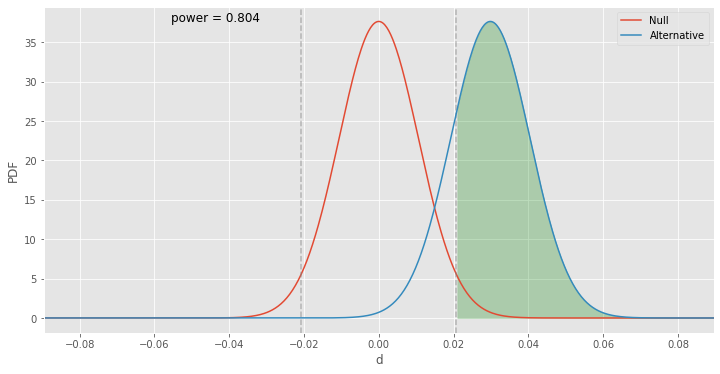

In [33]:
abplot(1700, 1700, bcr, d_hat, show_power=True)

## Calculate the minimum sample size

$$ n = \frac{(\bar{p})(1-\bar{p})(Z_\beta + Z_{\alpha/2})^2}{(p_B - p_A)^2} $$

$$ Z_\beta : \text{z-score that corresponds to the level of statistical power} $$
$$ Z_{\alpha/2} : \text{z-score that corresponds to the level of significance or confidence level} $$

$$\bar{p}: \text{pooled probability or average of } p_A \text{ and } p_B $$
$$p_A: \text{success rate of control group} $$
$$p_B: \text{success rate of experiment group} $$
$$n: \text{sample size for each variant} $$

In [34]:
min_sample_size(bcr=0.10, mde=0.02)

3842.026629963879

We can use the abplot function to check if it is correct.

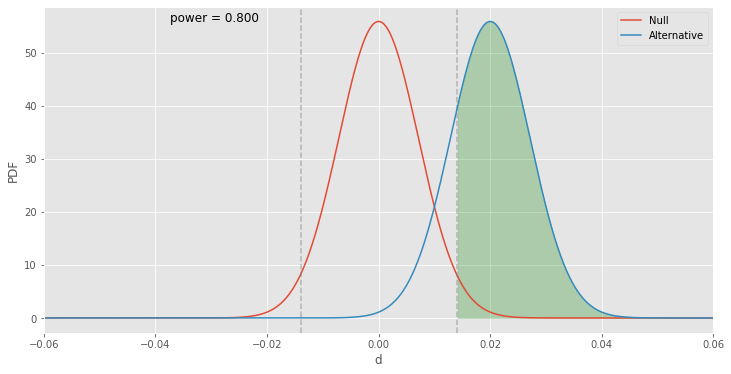

In [35]:
abplot(3843, 3843, 0.10, 0.02, show_power=True)

## Increase the Sample Size
For now, let's increase the sample size and do the test again.

In [37]:
# parameters for generate_data()
N_A = 6000
N_B = 6000
pa=0.10
pb=0.12

In [38]:
ab_data = generate_data(N_A, N_B, pa, pb)

In [39]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')
ab_summary

,converted,total,rate
group,,,
A,616,5991,0.102821
B,715,6009,0.118988


In [41]:
# parameters for abplot
n = N_A + N_B
p_A = ab_summary.loc['A', 'rate']
p_B = ab_summary.loc['B', 'rate']
bcr = p_A
d_hat = p_B - p_A

This time, we can see that the power if larger than 80%, since the sample size is very large.

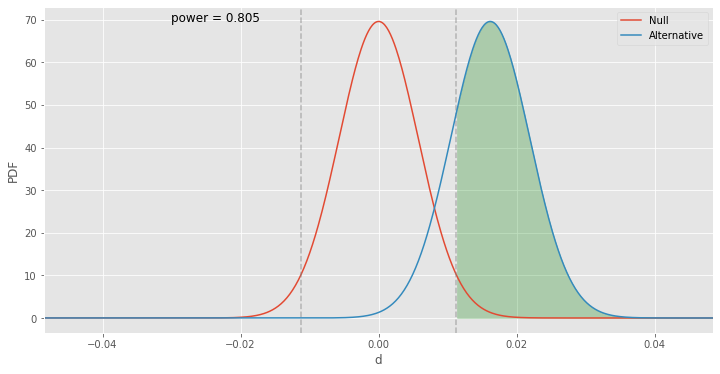

In [42]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)